In [54]:
import re
import sys
import warnings
import scipy.stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from time import sleep
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Embedding, Dropout

warnings.filterwarnings('ignore')

Load and Process Dataset

In [65]:
def get_data(headers, dtypes, filename):
    data = pd.read_csv(filename, encoding='utf8', skiprows=[0], names=headers, dtype=dtypes, na_filter=False)
    data = data.sample(frac=1).reset_index(drop=True)
    return data

hv = ['Anonymized Message', 'Valence']
dtv = {'Anonymized Message':'str', 'Valence':'float'}
v_data = get_data(hv, dtv, "Valence_Data.csv")

ha = ['Anonymized Message', 'Arousal']
dta = {'Anonymized Message':'str', 'Arousal':'float'}
a_data = get_data(ha, dta, "Arousal_Data.csv")

Pre-processing

In [67]:
def preprocess(messages):
    # set all words to lowercase and remove anything that isn't a letter or space
    messages = messages.apply(lambda x: x.lower()) #transform text to lowercase
    messages = messages.apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

    # find and remove all stop words
    stop = stopwords.words('english')
    messages = messages.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return messages

vX = preprocess(v_data['Anonymized Message'])
vy = v_data['Valence']

aX = preprocess(a_data['Anonymized Message'])
ay = a_data['Arousal']

Create Models

In [68]:
def get_model(Xin, yin):
    # setup a tokenizer to keep the most frequent 5000 words
    tokenizer = Tokenizer(num_words=2000, split=" ")
    tokenizer.fit_on_texts(Xin.values)
    
    # define input X
    X = tokenizer.texts_to_sequences(Xin.values)
    X = pad_sequences(X) # padding our text vector so they all have the same length
    
    # define expected output for training and testing
    y = pd.get_dummies(yin).values
    
    # setup and establish model with 9 outputs
    # output will be an array of length 9. 
    # the highest output value corresponds to the model's guess
    model = Sequential()
    model.add(Embedding(2000, 64, input_length=X.shape[1]))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
    model.add(LSTM(264, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    y = pd.get_dummies(yin).values
    
    # split X, y into training and testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return model, X_train, X_test, y_train, y_test

v_model, v_xtrain, v_xtest, v_ytrain, v_ytest = get_model(vX, vy)
a_model, a_xtrain, a_xtest, a_ytrain, a_ytest = get_model(aX, ay)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 44, 64)            128000    
                                                                 
 dropout_13 (Dropout)        (None, 44, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 44, 64)            33024     
                                                                 
 lstm_27 (LSTM)              (None, 264)               347424    
                                                                 
 dense_13 (Dense)            (None, 9)                 2385      
                                                                 
Total params: 510,833
Trainable params: 510,833
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"
________________________

Training Model(s)

In [69]:
def train_model(model, X, y):
    k = 10
    epochs = 8
    batch_size = 32
    kf = KFold(n_splits=k, random_state=None)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index, :], y[test_index, :]
      
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
        
        results= model.predict(X_test)
        preds = []
        actual = []
        for pred in results:
            preds.append(np.argmax(pred) + 1)
            
        for acts in y_test:
            actual.append(np.argmax(acts) + 1)
            
        r_val = scipy.stats.pearsonr(preds, actual)[0]
        print("R-val score of %.2f" % r_val)
    return model

print("Starting Valence training")
v_model = train_model(v_model, v_xtrain, v_ytrain)
v_model.save('valence_analysis.h5')

print("Finished Valence training. Now starting Arousal training")
a_model = train_model(a_model, a_xtrain, a_ytrain)
a_model.save('arousal_analysis.h5')

Epoch 1/8
131/131 - 22s - loss: 2.0373 - accuracy: 0.2182 - 22s/epoch - 170ms/step
Epoch 2/8
131/131 - 19s - loss: 1.5156 - accuracy: 0.4213 - 19s/epoch - 146ms/step
Epoch 3/8
131/131 - 19s - loss: 1.1888 - accuracy: 0.5307 - 19s/epoch - 147ms/step
Epoch 4/8
131/131 - 19s - loss: 1.0436 - accuracy: 0.5910 - 19s/epoch - 147ms/step
Epoch 5/8
131/131 - 19s - loss: 0.9742 - accuracy: 0.6263 - 19s/epoch - 149ms/step
Epoch 6/8
131/131 - 20s - loss: 0.9065 - accuracy: 0.6486 - 20s/epoch - 151ms/step
Epoch 7/8
131/131 - 20s - loss: 0.8883 - accuracy: 0.6579 - 20s/epoch - 152ms/step
Epoch 8/8
131/131 - 20s - loss: 0.8494 - accuracy: 0.6769 - 20s/epoch - 152ms/step
R-val score of 0.91
Epoch 1/8
131/131 - 20s - loss: 0.8535 - accuracy: 0.6798 - 20s/epoch - 150ms/step
Epoch 2/8
131/131 - 20s - loss: 0.8099 - accuracy: 0.6896 - 20s/epoch - 151ms/step
Epoch 3/8
131/131 - 21s - loss: 0.7884 - accuracy: 0.6916 - 21s/epoch - 157ms/step
Epoch 4/8
131/131 - 21s - loss: 0.7718 - accuracy: 0.7069 - 21s/epo

131/131 - 55s - loss: 0.9762 - accuracy: 0.6234 - 55s/epoch - 419ms/step
Epoch 2/8
131/131 - 56s - loss: 0.9299 - accuracy: 0.6311 - 56s/epoch - 428ms/step
Epoch 3/8
131/131 - 50s - loss: 0.9013 - accuracy: 0.6459 - 50s/epoch - 381ms/step
Epoch 4/8
131/131 - 51s - loss: 0.8896 - accuracy: 0.6469 - 51s/epoch - 390ms/step
Epoch 5/8
131/131 - 55s - loss: 0.8537 - accuracy: 0.6536 - 55s/epoch - 418ms/step
Epoch 6/8
131/131 - 55s - loss: 0.8392 - accuracy: 0.6659 - 55s/epoch - 422ms/step
Epoch 7/8
131/131 - 56s - loss: 0.8153 - accuracy: 0.6762 - 56s/epoch - 425ms/step
Epoch 8/8
131/131 - 56s - loss: 0.8153 - accuracy: 0.6692 - 56s/epoch - 425ms/step
R-val score of 0.85
Epoch 1/8
131/131 - 56s - loss: 0.8534 - accuracy: 0.6567 - 56s/epoch - 426ms/step
Epoch 2/8
131/131 - 54s - loss: 0.8207 - accuracy: 0.6654 - 54s/epoch - 413ms/step
Epoch 3/8
131/131 - 45s - loss: 0.8122 - accuracy: 0.6707 - 45s/epoch - 346ms/step
Epoch 4/8
131/131 - 46s - loss: 0.7769 - accuracy: 0.6839 - 46s/epoch - 348ms

Testing Model

Valence model has an accuracy of 61.05%
Valence model has a correlation coefficient of 0.93


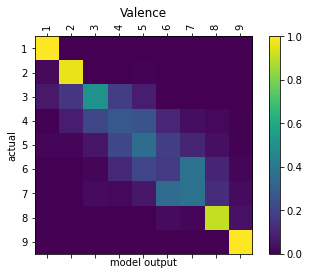

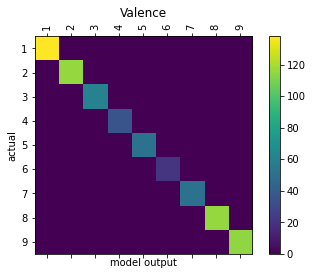

Arousal model has an accuracy of 45.94%
Arousal model has a correlation coefficient of 0.81


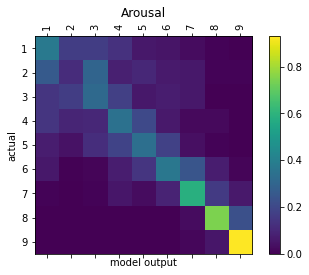

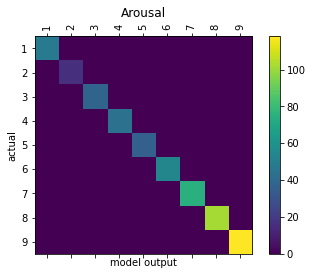

In [70]:
def test_model(col, model, X_test, y_test):
    # make predictions
    predictions = model.predict(X_test)
    
    # establish confusion matrix
    confusion = np.zeros([9,9])
    confusionA = np.zeros([9,9])
    correct = 0
    total = 0
    pred_vals = []
    actual_vals = []
    for i, prediction in enumerate(predictions):
        total += 1
        guess_i = np.argmax(prediction)
        actual_i = np.argmax(y_test[i])
        confusion[actual_i][guess_i] += 1
        if guess_i == actual_i:
            correct += 1
            confusionA[actual_i][guess_i] += 1
        pred_vals.append(guess_i + 1)
        actual_vals.append(actual_i + 1)

    r_val = scipy.stats.pearsonr(pred_vals, actual_vals)[0]
    acc = correct/total * 100

    print('%s model has an accuracy of %.2f%%' % (col, acc))
    print('%s model has a correlation coefficient of %.2f' % (col, r_val))
    
    # normalize confusion matrix
    for i in range(0, 9):
        sum = confusion[i].sum()
        if sum > 0:
            confusion[i] = confusion[i] / sum
       

    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)
    
    categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('model output')
    plt.ylabel('actual')
    plt.title(col)
    
    plt.show()

    
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusionA)
    fig.colorbar(cax)
    
    categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('model output')
    plt.ylabel('actual')
    plt.title(col)
    
    plt.show()
    
# make and plot predictions
test_model('Valence', v_model, v_xtest, v_ytest)
test_model('Arousal', a_model, a_xtest, a_ytest)